# Data

In [37]:
import pandas as pd
from IPython.display import display
import config
import utils

# Load Object Info
objects_df = pd.read_csv("benchmark_utils/objects_v1.csv")
print("Object Information Table:")
display(objects_df[['object', 'geometric_symmetry', 'location']])

Object Information Table:


,object,geometric_symmetry,location
0,a_cups,zinf,models/a_cups
1,a_lego_duplo,z2,models/a_lego_duplo
2,a_toy_airplane,no,models/a_toy_airplane
3,adjustable_wrench,no,models/adjustable_wrench
4,b_cups,zinf,models/b_cups
...,...,...,...
74,hello_kitty_bowl,no,models/hello_kitty_bowl
75,hello_kitty_plate,z2,models/hello_kitty_plate
76,doraemon_spoon,no,models/doraemon_spoon
77,tea_can1,zinf|x2,models/tea_can1


In [38]:
# Check Class Distribution
import importlib
importlib.reload(config)
args = config.get_config(args=[])
utils.check_class_distribution(args)

Checking class distribution for split: train
Data Dir: ./training_data_filtered/training_data/v2.2
Split Dir: ./training_data_filtered/training_data/splits/v2
Checking for preprocessed data at: c:\Users\GAUSS\Desktop\6D pose est\training_data_filtered\training_data\v2.2\preprocessed\train
Exists: True
Using preprocessed data from ./training_data_filtered/training_data/v2.2\preprocessed\train
Loading cached index from ./training_data_filtered/training_data/splits/v2\train_index.pkl...
Final samples: 29566 visible objects.
Total samples: 29566
Resolving object names...

ID    | Object Name                    | Count      | %    
------------------------------------------------------------
58    | wood_block                     | 2778       | 9.40%
57    | tuna_fish_can                  | 2726       | 9.22%
51    | pudding_box                    | 2552       | 8.63%
30    | gelatin_box                    | 2178       | 7.37%
8     | bleach_cleanser                | 1991       | 6.73%
42  

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [53]:
# Change these 
training_data_dir = "./training_data_filtered/training_data/v2.2"
split_dir = "./training_data_filtered/training_data/splits/v2"

In [56]:
def get_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

def get_scene_idx(scene_name):
    scene_indices = -1
    with open(os.path.join(split_dir, "val.txt"), 'r') as f:
        for idx, line in enumerate(f):
            if scene_name in line:
                scene_indices = idx
                break
    return scene_indices

idx = get_scene_idx("1-42-6")

In [58]:
rgb_files, depth_files, label_files, meta_files = get_split_files('val')
print(len(meta_files))

236


In [59]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

C:\Users\GAUSS\AppData\Local\Temp\ipykernel_195668\3752261350.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('rainbow', NUM_OBJECTS)


## Get familiar with the data

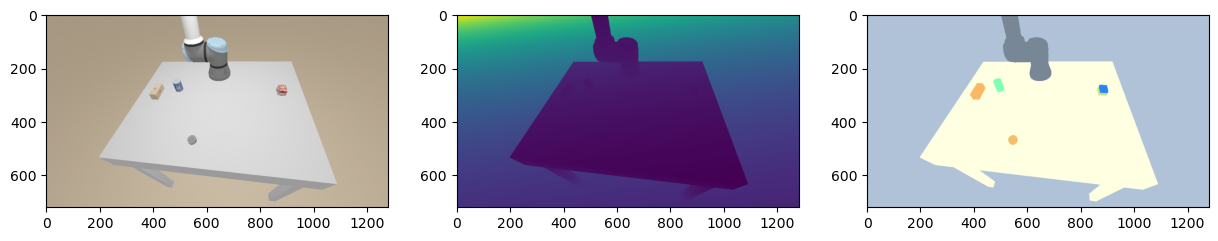

In [60]:
meta = load_pickle(meta_files[idx])
rgb = np.array(Image.open(rgb_files[idx])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[idx])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[idx]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

segmentation mask unique labels: [14 39 51 57 58 79 80 81]
Object names: ['cracker_box', 'master_chef_can', 'pudding_box', 'tuna_fish_can', 'wood_block']
Object IDs: [14 39 51 57 58]
Valid pixel counts for each object ID:
Object ID 14: 940 pixels
Object ID 39: 1470 pixels
Object ID 51: 446 pixels
Object ID 57: 997 pixels
Object ID 58: 2327 pixels


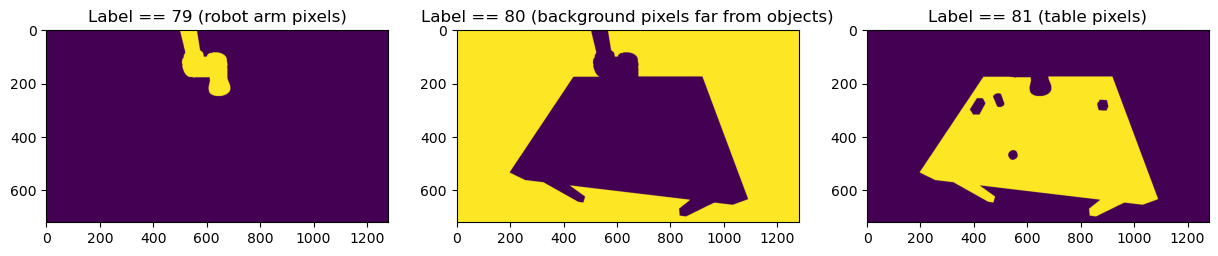

In [61]:
print("segmentation mask unique labels:", np.unique(label))
print(f"Object names: {meta['object_names']}")
print(f"Object IDs: {meta['object_ids']}")

# count valid pixels for each object
valid_pixel_counts = {}
for obj_id in meta['object_ids']:
    count = np.sum(label == obj_id)
    valid_pixel_counts[obj_id] = count
    
print("Valid pixel counts for each object ID:")
for obj_id, count in valid_pixel_counts.items():
    print(f"Object ID {obj_id}: {count} pixels")
    
# show what label=79/80/81 means
img_79 = label == 79
img_80 = label == 80
img_81 = label == 81
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Label == 79 (robot arm pixels)")
plt.imshow(img_79)
plt.subplot(1, 3, 2)
plt.title("Label == 80 (background pixels far from objects)")
plt.imshow(img_80)
plt.subplot(1, 3, 3)
plt.title("Label == 81 (table pixels)")
plt.imshow(img_81)
plt.show()

In [63]:
poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
print(poses_world.shape)    # 4D transformation matrix, homogeneous coordinates

box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
print(box_sizes.shape)    # xyz scale

(5, 4, 4)
(5, 3)


## Lift depth to point cloud

In [64]:
intrinsic = meta['intrinsic']
z = depth
v, u = np.indices(z.shape)
uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
print(points_viewer.shape)
# points_viewer = points_viewer[::-1, ::-1, :]

(720, 1280, 3)


In [65]:
import open3d
points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
pcd = open3d.geometry.PointCloud()
pcd.points = points
pcd.colors = colors
open3d.visualization.draw_geometries([pcd])
# will open another window to show the point cloud

## Draw bounding boxes of poses on 2D image
If you are curious, take a look at `utils.py`. It is very simple.

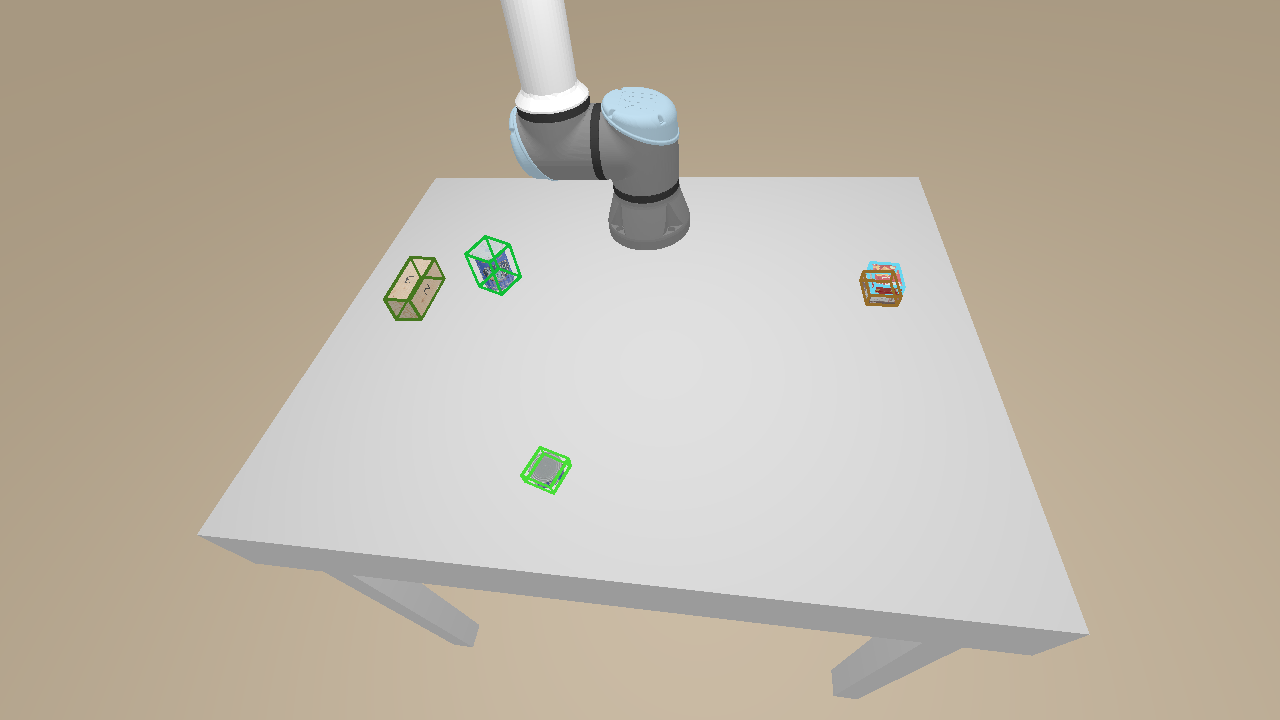

In [66]:
boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    utils.draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))

## Test data
Test data has everything but the poses. Testing data and training data are from the same distribution.

In [15]:
load_pickle("./testing_data_pose_filtered/testing_data/v2.2/1-1-1_meta.pkl").keys()

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

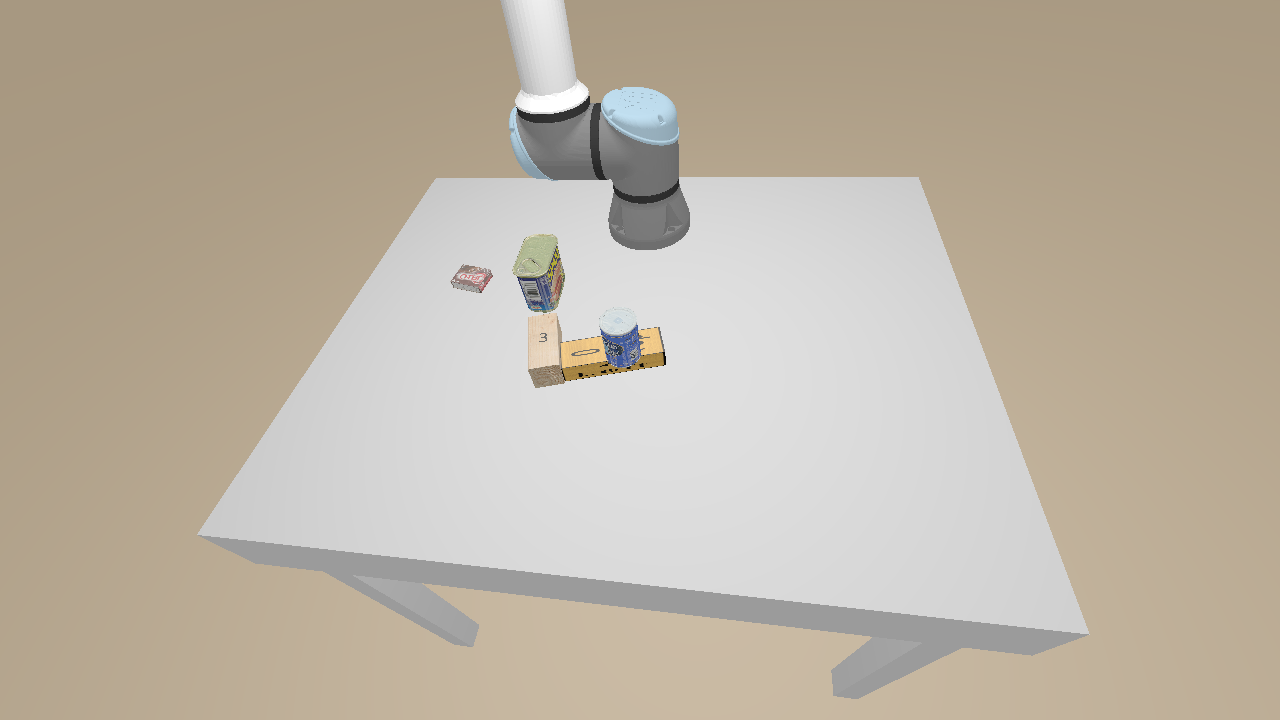

In [16]:
Image.open("./testing_data_pose_filtered/testing_data/v2.2/1-1-1_color_kinect.png")

## ICP

### Coordinate Frame Table

| Frame Name         | Definition                                                                 | Typical Data Example                |
|-------------------|----------------------------------------------------------------------------|-------------------------------------|
| Object Canonical  | Mesh model's own coordinate system, centered and scaled to canonical size   | `mesh_points` (sampled from mesh)   |
| Camera            | Camera's coordinate system, origin at camera center                         | `points` (from depth image)         |
| World             | Global scene coordinate system, fixed for dataset/environment               | Final object pose in world frame    |

- **Object Canonical → Camera:** Use ICP to align mesh to observed points.
- **Camera → World:** Use camera extrinsic matrix to convert object pose to world frame.
- **Object Canonical → World:** Apply ground-truth pose matrix to mesh points.


# Loss

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def plot_point_clouds(gt_pts, pred_pts, title, draw_lines=True, loss_type="L2"):
    """
    Visualizes Ground Truth (Blue) vs Predicted (Red) points.
    Draws lines to show which points are being compared by the loss function.
    """
    plt.figure(figsize=(8, 8))
    
    # Convert to numpy
    gt = gt_pts.numpy()
    pred = pred_pts.numpy()
    
    plt.scatter(gt[:, 0], gt[:, 1], c='blue', label='Ground Truth', s=50, alpha=0.6)
    plt.scatter(pred[:, 0], pred[:, 1], c='red', label='Prediction', s=50, alpha=0.6)
    
    # Draw correspondence lines
    if draw_lines:
        if loss_type == "L2":
            # L2 compares index i to index i
            for i in range(len(gt)):
                plt.plot([gt[i, 0], pred[i, 0]], [gt[i, 1], pred[i, 1]], 'k-', alpha=0.2)
        elif loss_type == "Chamfer":
            # Chamfer compares to NEAREST neighbor
            # Compute distance matrix
            dists = torch.cdist(gt_pts.unsqueeze(0), pred_pts.unsqueeze(0)).squeeze(0)
            # For each GT point, find nearest Pred
            min_indices = torch.argmin(dists, dim=1)
            for i in range(len(gt)):
                nearest_idx = min_indices[i]
                plt.plot([gt[i, 0], pred[nearest_idx, 0]], [gt[i, 1], pred[nearest_idx, 1]], 'g-', alpha=0.2)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

## 1. The "Aligned" Case (Asymmetric Objects)

For asymmetric objects (like a shoe or a mug), there is only one correct pose.
Our network predicts a rotation $R_{pred}$ and translation $t_{pred}$.
We transform the canonical points $P$ to get predicted points: $P_{pred} = R_{pred} P + t_{pred}$.
We compare this to ground truth: $P_{gt} = R_{gt} P + t_{gt}$.

Since both sets of points originate from the same canonical $P$, $P_{pred}[i]$ corresponds physically to $P_{gt}[i]$.

L2 Loss (ADD): 0.1652


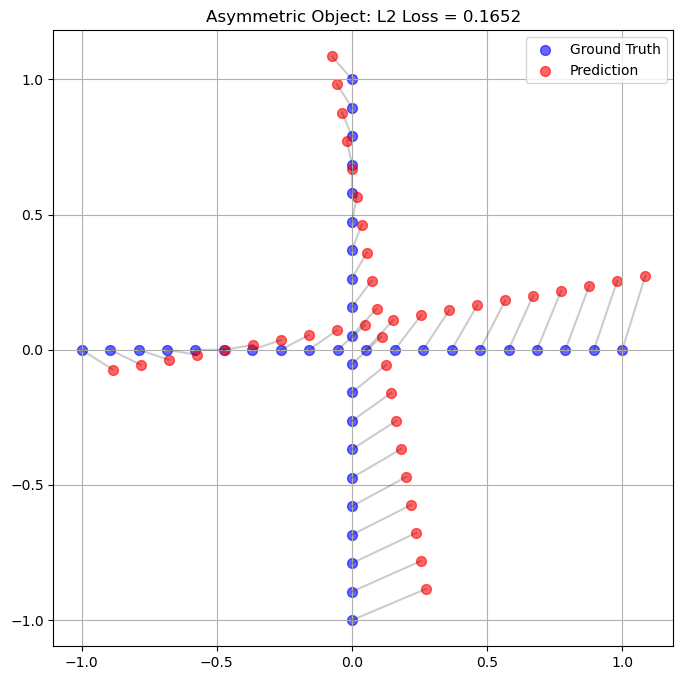

In [18]:
# Generate an asymmetric shape (e.g., an 'L' shape)
num_points = 20
x = torch.linspace(-1, 1, num_points)
y = torch.zeros(num_points)
pts1 = torch.stack([x, y], dim=1)
pts2 = torch.stack([torch.zeros(num_points), x], dim=1)
# Combine to make an L shape
canonical_points = torch.cat([pts1, pts2], dim=0)

# Ground Truth Pose (Identity)
gt_points = canonical_points

# Predicted Pose (Slight Rotation + Noise)
theta = np.radians(10) # 10 degree error
R_pred = torch.tensor([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]], dtype=torch.float32)
pred_points = canonical_points @ R_pred.T + 0.1 # Add translation

# Calculate L2 Loss (ADD)
# We compare point i to point i
l2_loss = torch.norm(pred_points - gt_points, dim=1).mean()

print(f"L2 Loss (ADD): {l2_loss.item():.4f}")

plot_point_clouds(gt_points, pred_points, f"Asymmetric Object: L2 Loss = {l2_loss:.4f}", loss_type="L2")

**Observation**: The black lines connect corresponding points (index-to-index). Since the rotation error is small, the lines are short. The loss accurately reflects the pose error.

## 2. The Symmetry Problem

Now consider a symmetric object, like a circular plate.
Rotating the plate by 180 degrees results in the **same geometric shape**.
However, if we simply rotate the points, point $i$ moves to the opposite side.

If the network predicts a 180-degree rotation (which is a valid pose for a symmetric object), the standard L2 loss will be huge because it compares point $i$ (now on the left) to point $i$ (originally on the right).

L2 Loss (ADD) for Symmetric Pose: 2.0000
The loss is high, even though the shape overlaps perfectly!


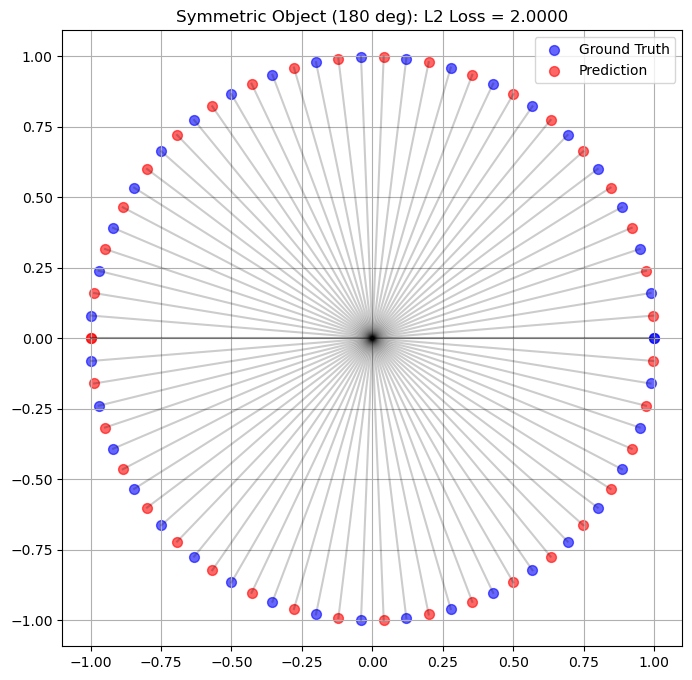

In [19]:
# Generate a symmetric shape (Circle)
angles = torch.linspace(0, 2*np.pi, 40)
x = torch.cos(angles)
y = torch.sin(angles)
circle_points = torch.stack([x, y], dim=1)

gt_points_sym = circle_points

# Predicted Pose: 180 degree rotation (Symmetric equivalent)
# Geometrically, this is the SAME object pose.
theta_sym = np.radians(180) 
R_sym = torch.tensor([[np.cos(theta_sym), -np.sin(theta_sym)], [np.sin(theta_sym), np.cos(theta_sym)]], dtype=torch.float32)
pred_points_sym = circle_points @ R_sym.T

# Calculate L2 Loss (ADD)
# This will be HIGH because point 0 is compared to point 0's rotated position (opposite side)
l2_loss_sym = torch.norm(pred_points_sym - gt_points_sym, dim=1).mean()

print(f"L2 Loss (ADD) for Symmetric Pose: {l2_loss_sym.item():.4f}")
print("The loss is high, even though the shape overlaps perfectly!")

plot_point_clouds(gt_points_sym, pred_points_sym, f"Symmetric Object (180 deg): L2 Loss = {l2_loss_sym:.4f}", loss_type="L2")

**Observation**: The black lines cross the entire circle! The loss is calculating the diameter of the circle, penalizing a perfectly valid symmetric pose. This confuses the network.

## 3. The Solution: Chamfer Distance (ADD-S)

For symmetric objects, we don't care *which* point matches *which*. We just want to know: **"Is the predicted shape close to the ground truth shape?"**

Chamfer distance calculates, for each predicted point, the distance to the **nearest** ground truth point, regardless of index.

Chamfer Loss (ADD-S): 0.1611
The loss is near zero, correctly recognizing the valid pose.


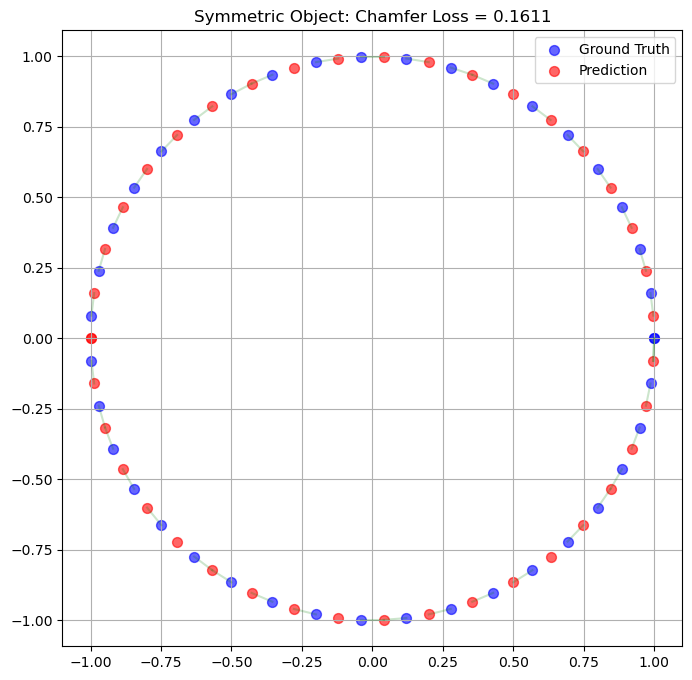

In [20]:
def chamfer_distance_demo(p1, p2):
    # p1, p2: (N, 2)
    dists = torch.cdist(p1.unsqueeze(0), p2.unsqueeze(0)).squeeze(0) # (N, N) matrix
    
    # Distance from p1 to nearest in p2
    min_dist1, _ = torch.min(dists, dim=1)
    
    # Distance from p2 to nearest in p1
    min_dist2, _ = torch.min(dists, dim=0)
    
    return torch.mean(min_dist1) + torch.mean(min_dist2)

# Calculate Chamfer Loss
chamfer_loss = chamfer_distance_demo(pred_points_sym, gt_points_sym)

print(f"Chamfer Loss (ADD-S): {chamfer_loss.item():.4f}")
print("The loss is near zero, correctly recognizing the valid pose.")

plot_point_clouds(gt_points_sym, pred_points_sym, f"Symmetric Object: Chamfer Loss = {chamfer_loss:.4f}", loss_type="Chamfer")

**Observation**: The green lines connect each point to its nearest neighbor. Since the shapes overlap perfectly, the lines are tiny (length ~0), and the loss is effectively zero. This allows the network to learn symmetric poses correctly.

# ICP Analysis: Improvement & Failure Cases

We will now analyze the impact of ICP by comparing the predictions before and after refinement.
1. **Improved Cases**: Scenes where ICP significantly corrected the pose.
2. **Difficult Cases**: Scenes where even ICP failed to recover the correct pose.

In [21]:
import json
import numpy as np
import os
import cv2
import torch
from data import PoseDataset
import config
import loss as loss_utils
import utils
from PIL import Image
import matplotlib.pyplot as plt

# 1. Load Predictions
print("Loading predictions...")
with open("pointnet_predictions.json", "r") as f:
    preds_no_icp = json.load(f)
    
with open("pointnet_predictions_icp.json", "r") as f:
    preds_icp = json.load(f)

# 2. Load Dataset (Validation Split)
# We use a small subset or just iterate until we find what we need
args = config.get_config(args=[])
val_dataset = PoseDataset("val", args.training_data_dir, args.split_dir, num_points=1024)

print(f"Loaded {len(val_dataset)} validation samples.")

Loading predictions...
Checking for preprocessed data at: c:\Users\GAUSS\Desktop\6D pose est\training_data_filtered\training_data\v2.2\preprocessed\val
Exists: True
Using preprocessed data from ./training_data_filtered/training_data/v2.2\preprocessed\val
Loading cached index from ./training_data_filtered/training_data/splits/v2\val_index.pkl...
Final samples: 1717 visible objects.
Loaded 1717 validation samples.


In [22]:
# 3. Find Interesting Scenes
improved_sample = None
difficult_sample = None

print("Searching for interesting cases...")

# Iterate through dataset
for i in range(len(val_dataset)):
    sample = val_dataset[i]
    scene_idx, obj_id = val_dataset.samples[i]
    
    # Get Scene Name from file path
    rgb_path = val_dataset.rgb_files[scene_idx]
    scene_name = os.path.basename(rgb_path).split("_")[0]
    
    # Get Predictions
    if scene_name not in preds_no_icp or scene_name not in preds_icp:
        continue
        
    pose_no_icp = preds_no_icp[scene_name]["poses_world"][obj_id]
    pose_icp = preds_icp[scene_name]["poses_world"][obj_id]
    
    if pose_no_icp is None or pose_icp is None:
        continue
        
    # Convert to Matrix
    T_pred_no_icp = np.array(pose_no_icp) # World Frame
    T_pred_icp = np.array(pose_icp)       # World Frame
    
    # Get GT (World Frame)
    # Note: val_dataset[i] returns GT in Camera Frame (gt_rot, gt_t_residual + centroid)
    # But we can get World Frame from metadata directly
    with open(val_dataset.meta_files[scene_idx], "rb") as f:
        meta = pickle.load(f)
    T_gt_world = np.array(meta['poses_world'][obj_id])
    
    # Calculate Errors (Rotation only for now, as translation is usually good)
    R_pred_no_icp = T_pred_no_icp[:3, :3]
    R_pred_icp = T_pred_icp[:3, :3]
    R_gt = T_gt_world[:3, :3]
    
    sym = sample['sym_str']
    
    rot_err_no_icp = loss_utils.compute_symmetry_aware_loss(R_pred_no_icp, R_gt, sym)
    rot_err_icp = loss_utils.compute_symmetry_aware_loss(R_pred_icp, R_gt, sym)
    
    # Check for Improvement
    # Criteria: Bad before (>15 deg), Good after (<5 deg)
    if improved_sample is None:
        if rot_err_no_icp > 15.0 and rot_err_icp < 5.0:
            improved_sample = {
                'scene_name': scene_name,
                'obj_id': obj_id,
                'rgb_path': rgb_path,
                'meta': meta,
                'T_no_icp': T_pred_no_icp,
                'T_icp': T_pred_icp,
                'err_before': rot_err_no_icp,
                'err_after': rot_err_icp,
                'obj_dims': sample['obj_dims'],
                'scale': sample['scale'].numpy()
            }
            print(f"Found Improved Case: {scene_name} (Obj {obj_id}) | {rot_err_no_icp:.1f}° -> {rot_err_icp:.1f}°")

    # Check for Difficult Case
    # Criteria: Still bad after ICP (> 20 deg)
    if difficult_sample is None:
        if rot_err_icp > 20.0:
            difficult_sample = {
                'scene_name': scene_name,
                'obj_id': obj_id,
                'rgb_path': rgb_path,
                'meta': meta,
                'T_no_icp': T_pred_no_icp,
                'T_icp': T_pred_icp,
                'err_before': rot_err_no_icp,
                'err_after': rot_err_icp,
                'obj_dims': sample['obj_dims'],
                'scale': sample['scale'].numpy()
            }
            print(f"Found Difficult Case: {scene_name} (Obj {obj_id}) | Final Err: {rot_err_icp:.1f}°")
            
    if improved_sample and difficult_sample:
        break

Searching for interesting cases...
Found Difficult Case: 1-42-6 (Obj 51) | Final Err: 34.5°
Found Difficult Case: 1-42-6 (Obj 51) | Final Err: 34.5°


No Improved Case sample found.
Visualizing Difficult Case: 1-42-6 (Obj 51)
Error Improvement: 37.69° -> 34.52°


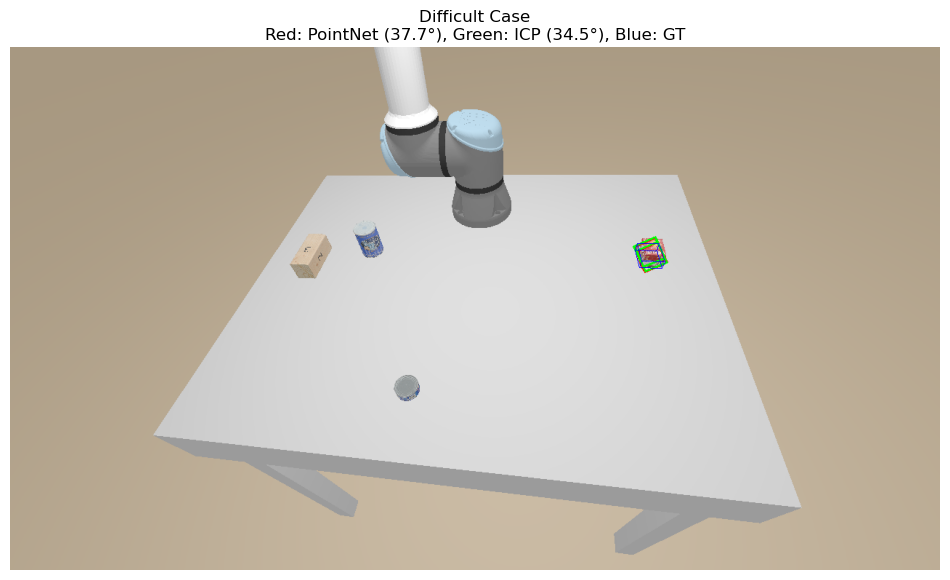

In [23]:
def visualize_comparison(sample, title_prefix):
    if sample is None:
        print(f"No {title_prefix} sample found.")
        return

    print(f"Visualizing {title_prefix}: {sample['scene_name']} (Obj {sample['obj_id']})")
    print(f"Error Improvement: {sample['err_before']:.2f}° -> {sample['err_after']:.2f}°")
    
    # Load Image
    img = np.array(Image.open(sample['rgb_path']))
    
    # Draw Boxes
    # 1. Ground Truth (Blue)
    # We need to reconstruct T_gt from meta
    T_gt_world = np.array(sample['meta']['poses_world'][sample['obj_id']])
    
    # 2. PointNet (Red)
    T_no_icp = sample['T_no_icp']
    
    # 3. ICP (Green)
    T_icp = sample['T_icp']
    
    # Intrinsics/Extrinsics
    K = np.array(sample['meta']['intrinsic'])
    extrinsic = np.array(sample['meta']['extrinsic'])
    
    size = sample['obj_dims'] * sample['scale']
    
    # Draw PointNet (Red)
    utils.draw_projected_box3d(img, T_no_icp[:3,3], size, T_no_icp[:3,:3], extrinsic, K, color=(255, 0, 0), thickness=2)
    
    # Draw ICP (Green) - The "Improved" one
    utils.draw_projected_box3d(img, T_icp[:3,3], size, T_icp[:3,:3], extrinsic, K, color=(0, 255, 0), thickness=2)
    
    # Draw GT (Blue) - Reference
    utils.draw_projected_box3d(img, T_gt_world[:3,3], size, T_gt_world[:3,:3], extrinsic, K, color=(0, 0, 255), thickness=1)
    
    plt.figure(figsize=(12, 8))
    plt.title(f"{title_prefix}\nRed: PointNet ({sample['err_before']:.1f}°), Green: ICP ({sample['err_after']:.1f}°), Blue: GT")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Visualize
visualize_comparison(improved_sample, "Improved Case")
visualize_comparison(difficult_sample, "Difficult Case")